<a href="https://colab.research.google.com/github/moon2su/ML-programming/blob/main/MHEALTH_1D_CNN_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""base_dir = "/content/drive/MyDrive/Colab Notebooks/mhealth+dataset/MHEALTHDATASET"

# mHealth README 기반 컬럼 이름
COLUMNS = [
    "chest_acc_x", "chest_acc_y", "chest_acc_z",
    "ECG_1", "ECG_2",
    "ankle_acc_x", "ankle_acc_y", "ankle_acc_z",
    "ankle_gyro_x", "ankle_gyro_y", "ankle_gyro_z",
    "ankle_mag_x", "ankle_mag_y", "ankle_mag_z",
    "arm_acc_x", "arm_acc_y", "arm_acc_z",
    "arm_gyro_x", "arm_gyro_y", "arm_gyro_z",
    "arm_mag_x", "arm_mag_y", "arm_mag_z",
    "activity_label"
]

def load_one_subject(path, columns=COLUMNS):

    # 한 명(subject)의 .log 파일을 읽어서 DataFrame으로 반환.
    # - 탭 구분(\t)
    # - 헤더 없음(header=None)
    # - 첫 행에 이상한 문자열이 들어왔던 경우를 대비해, 숫자로 캐스팅 안되면 드랍 처리 옵션 포함

    df = pd.read_csv(path, sep="\t", header=None, names=columns)

    # 간혹 첫 행이 헤더처럼 들어간 경우 방지: 마지막 열이 숫자형이 아닌 행 제거
    # (정상 데이터는 activity_label이 항상 숫자여야 함)
    mask_numeric = pd.to_numeric(df["activity_label"], errors="coerce").notna()
    if not mask_numeric.all():
        df = df[mask_numeric].reset_index(drop=True)

    # 숫자형으로 확실히 변환 (메모리 절약 위해 float32 권장)
    for c in columns[:-1]:
        df[c] = pd.to_numeric(df[c], errors="coerce").astype(np.float32)
    df["activity_label"] = pd.to_numeric(df["activity_label"], errors="coerce").astype(np.int16)

    return df

# subject 파일 목록(정렬)
paths = sorted(glob.glob(os.path.join(base_dir, "mHealth_subject*.log")),
               key=lambda p: int(re.search(r"subject(\d+)\.log$", p).group(1)))

dfs = []
for p in paths:
    sid = int(re.search(r"subject(\d+)\.log$", p).group(1))
    df_sub = load_one_subject(p)
    df_sub["subject"] = sid
    dfs.append(df_sub)

df_all = pd.concat(dfs, ignore_index=True)

df_all"""

<>:40: SyntaxWarning: invalid escape sequence '\d'
<>:40: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-2277895329.py:40: SyntaxWarning: invalid escape sequence '\d'
  key=lambda p: int(re.search(r"subject(\d+)\.log$", p).group(1)))


'base_dir = "/content/drive/MyDrive/Colab Notebooks/mhealth+dataset/MHEALTHDATASET"\n\n# mHealth README 기반 컬럼 이름\nCOLUMNS = [\n    "chest_acc_x", "chest_acc_y", "chest_acc_z",\n    "ECG_1", "ECG_2",\n    "ankle_acc_x", "ankle_acc_y", "ankle_acc_z",\n    "ankle_gyro_x", "ankle_gyro_y", "ankle_gyro_z",\n    "ankle_mag_x", "ankle_mag_y", "ankle_mag_z",\n    "arm_acc_x", "arm_acc_y", "arm_acc_z",\n    "arm_gyro_x", "arm_gyro_y", "arm_gyro_z",\n    "arm_mag_x", "arm_mag_y", "arm_mag_z",\n    "activity_label"\n]\n\ndef load_one_subject(path, columns=COLUMNS):\n\n    # 한 명(subject)의 .log 파일을 읽어서 DataFrame으로 반환.\n    # - 탭 구분(\t)\n    # - 헤더 없음(header=None)\n    # - 첫 행에 이상한 문자열이 들어왔던 경우를 대비해, 숫자로 캐스팅 안되면 드랍 처리 옵션 포함\n\n    df = pd.read_csv(path, sep="\t", header=None, names=columns)\n\n    # 간혹 첫 행이 헤더처럼 들어간 경우 방지: 마지막 열이 숫자형이 아닌 행 제거\n    # (정상 데이터는 activity_label이 항상 숫자여야 함)\n    mask_numeric = pd.to_numeric(df["activity_label"], errors="coerce").notna()\n    if not mask_numeric.all():\n   

In [2]:
"""save_path = "/content/drive/MyDrive/Colab Notebooks/mhealth+dataset/MHEALTHDATASET/mhealth_combined.csv"  # 필요시 경로 수정
df_all.to_csv(save_path, index=False)
print("Saved to:", save_path)"""

'save_path = "/content/drive/MyDrive/Colab Notebooks/mhealth+dataset/MHEALTHDATASET/mhealth_combined.csv"  # 필요시 경로 수정\ndf_all.to_csv(save_path, index=False)\nprint("Saved to:", save_path)'

In [3]:
import random
import warnings
import pandas as pd
import os, re, glob
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from collections import Counter

In [4]:
warnings.filterwarnings("ignore")

# 재현성
SEED = 42
random.seed(SEED); np.random.seed(SEED)
import tensorflow as tf
tf.random.set_seed(SEED)

DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/mhealth+dataset/MHEALTHDATASET/mhealth_combined.csv"

In [5]:
df = pd.read_csv(DATA_PATH)

print("원본 shape:", df.shape)
print("컬럼:", list(df.columns))

# 라벨/피험자 분포 (오름차순)
print("\n[라벨 분포 - 원본]")
print(df['activity_label'].value_counts().sort_index())

print("\n[Subject 분포 - 원본]")
print(df['subject'].value_counts().sort_index())

# 라벨 0 제외
df_nz = df[df['activity_label'] != 0].copy()
print("\n라벨 0 제거 후 shape:", df_nz.shape)

print("\n[라벨 분포 - 0 제외]")
print(df_nz['activity_label'].value_counts().sort_index())

print("\n[Subject 분포 - 0 제외]")
print(df_nz['subject'].value_counts().sort_index())

원본 shape: (1215745, 25)
컬럼: ['chest_acc_x', 'chest_acc_y', 'chest_acc_z', 'ECG_1', 'ECG_2', 'ankle_acc_x', 'ankle_acc_y', 'ankle_acc_z', 'ankle_gyro_x', 'ankle_gyro_y', 'ankle_gyro_z', 'ankle_mag_x', 'ankle_mag_y', 'ankle_mag_z', 'arm_acc_x', 'arm_acc_y', 'arm_acc_z', 'arm_gyro_x', 'arm_gyro_y', 'arm_gyro_z', 'arm_mag_x', 'arm_mag_y', 'arm_mag_z', 'activity_label', 'subject']

[라벨 분포 - 원본]
activity_label
0     872550
1      30720
2      30720
3      30720
4      30720
5      30720
6      28315
7      29441
8      29337
9      30720
10     30720
11     30720
12     10342
Name: count, dtype: int64

[Subject 분포 - 원본]
subject
1     161280
2     130561
3     122112
4     116736
5     119808
6      98304
7     104448
8     129024
9     135168
10     98304
Name: count, dtype: int64

라벨 0 제거 후 shape: (343195, 25)

[라벨 분포 - 0 제외]
activity_label
1     30720
2     30720
3     30720
4     30720
5     30720
6     28315
7     29441
8     29337
9     30720
10    30720
11    30720
12    10342
Name: co

In [6]:
df_nz

,chest_acc_x,chest_acc_y,chest_acc_z,ECG_1,ECG_2,ankle_acc_x,ankle_acc_y,ankle_acc_z,ankle_gyro_x,ankle_gyro_y,...,arm_acc_y,arm_acc_z,arm_gyro_x,arm_gyro_y,arm_gyro_z,arm_mag_x,arm_mag_y,arm_mag_z,activity_label,subject
6656,-9.7788,0.55690,1.19750,0.008373,-0.033490,2.6493,-9.4517,0.37683,-0.20965,-0.88931,...,-9.0618,1.81770,-0.058824,-0.93429,-0.344830,0.355370,-0.37003,-0.35020,1,1
6657,-9.7733,0.27880,0.73036,-0.025118,-0.025118,2.4157,-9.5306,0.40179,-0.20965,-0.88931,...,-9.2048,1.51890,-0.058824,-0.93429,-0.344830,0.719910,0.17803,0.37363,1,1
6658,-9.8609,0.11561,0.79988,0.025118,0.016745,2.3865,-9.5991,0.48141,-0.20037,-0.86867,...,-9.1945,1.55070,-0.058824,-0.93429,-0.344830,0.355370,-0.37003,-0.35020,1,1
6659,-9.7409,0.17652,0.88957,0.180010,0.129770,2.3758,-9.5997,0.42919,-0.20037,-0.86867,...,-9.1746,1.54130,-0.078431,-0.93429,-0.340520,0.357180,-0.18858,-0.35198,1,1
6660,-9.7821,0.21637,0.90368,0.092098,0.046049,2.3239,-9.5406,0.40038,-0.20037,-0.86867,...,-9.2039,1.61270,-0.078431,-0.93429,-0.340520,-0.001887,-0.18867,-0.72017,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213641,-21.9470,3.92360,-6.22580,0.133960,0.163270,-2.4873,-19.2330,3.46140,0.61967,-0.33771,...,-4.9652,2.48090,-0.437250,-1.01850,0.079741,-0.213000,14.60600,8.51390,12,10
1213642,-21.9140,2.75210,-12.27900,-0.087912,-0.083726,-21.5910,-19.4370,-6.04190,0.61967,-0.33771,...,-10.2130,3.65600,-0.437250,-1.01850,0.079741,8.618500,36.00000,-21.12600,12,10
1213643,-21.8140,-2.72740,-12.70900,-0.309790,-0.200940,7.5433,-19.2450,-2.66800,0.61967,-0.33771,...,-18.7050,4.46060,-0.437250,-1.01850,0.079741,16.953000,7.65350,-34.39500,12,10
1213644,-21.7900,-3.92290,-7.27940,-0.443750,-0.259550,3.0142,-19.3340,-7.70740,0.71058,-0.27017,...,-18.6980,1.15880,-0.425490,-1.03700,0.084052,25.375000,-29.79600,4.05460,12,10


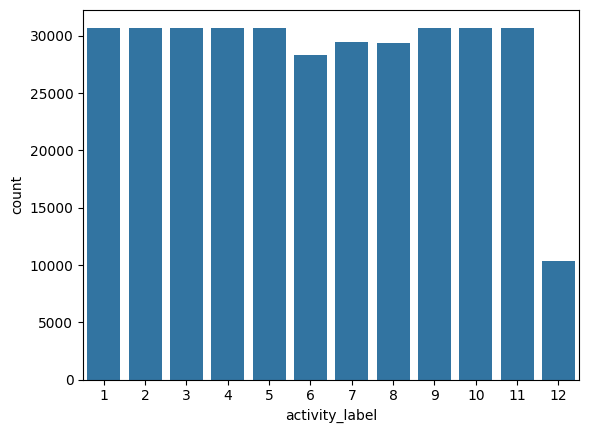

In [7]:
sns.countplot(x = "activity_label", data = df_nz, order = sorted(df_nz['activity_label'].unique()))
plt.show()

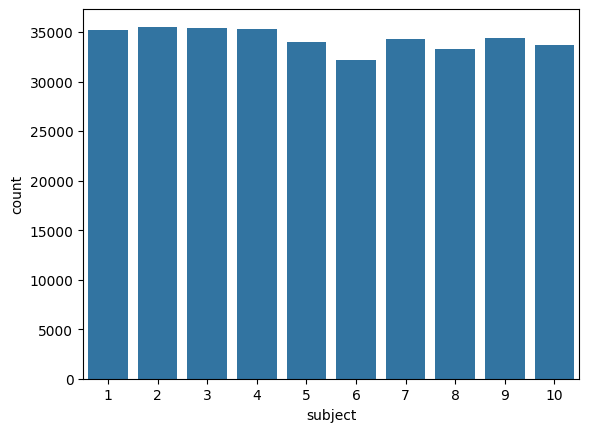

In [8]:
sns.countplot(x = "subject", data = df_nz, order = sorted(df_nz['subject'].unique()))
plt.show()

In [9]:
act_counts = df_nz['activity_label'].value_counts().sort_index()
subj_counts = df_nz['subject'].value_counts().sort_index()

print(act_counts)
print("\n------------------\n")
print(subj_counts)

activity_label
1     30720
2     30720
3     30720
4     30720
5     30720
6     28315
7     29441
8     29337
9     30720
10    30720
11    30720
12    10342
Name: count, dtype: int64

------------------

subject
1     35174
2     35532
3     35380
4     35328
5     33947
6     32205
7     34253
8     33332
9     34354
10    33690
Name: count, dtype: int64


In [10]:
# 결측치/중복 처리
df_nz = df_nz.dropna().drop_duplicates().reset_index(drop=True)

# 라벨 타입/범위 확인
labels_unique = sorted(df_nz['activity_label'].unique())
print("사용 라벨:", labels_unique)

사용 라벨: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12)]


In [11]:
# segmentation
# feature 컬럼 자동 선정 (라벨/subject 제외)
feature_cols = [c for c in df_nz.columns if c not in ['activity_label','subject']]

def fit_scaler(train_df, features):
    sc = StandardScaler()
    # 누수 방지: train으로만 fit
    sc.fit(train_df[features].values)
    return sc

def apply_scaler(df_part, features, sc):
    out = df_part.copy()
    out.loc[:, features] = sc.transform(out[features].values)
    return out

def make_windows(df_part, features, window=128, stride=64, min_label_frac=0.6):
    X_list, y_list, g_list = [], [], []
    for sid, part in df_part.groupby("subject", sort=False):
        X = part[features].values
        y = part["activity_label"].values
        n = len(part)
        for st in range(0, n - window + 1, stride):
            ed = st + window
            seg_y = y[st:ed]
            lab, cnt = Counter(seg_y).most_common(1)[0]
            if cnt/len(seg_y) >= min_label_frac:
                X_list.append(X[st:ed])
                y_list.append(lab)
                g_list.append(sid)
    if not X_list:
        return np.empty((0, window, len(features))), np.array([]), np.array([])
    return np.stack(X_list), np.array(y_list, int), np.array(g_list, int)

In [12]:
# subject-wise
# 10명을 5개 쌍으로 고정
fold_pairs = [(1,2), (3,4), (5,6), (7,8), (9,10)]

def split_by_subject_pairs(df_all, test_pair):
    test_mask = df_all['subject'].isin(test_pair)
    df_train = df_all[~test_mask].copy()
    df_test  = df_all[test_mask].copy()
    return df_train, df_test

In [13]:
# label encoding
def make_label_mapper(train_labels):
    uniq = sorted(np.unique(train_labels))
    to_idx = {lab:i for i,lab in enumerate(uniq)}
    return to_idx

def map_labels(arr, mapper):
    return np.array([mapper[a] for a in arr], dtype=int)

In [14]:
from tensorflow.keras import layers, models

def build_cnn1d(in_shape, num_classes, p_drop=0.3):
    inp = layers.Input(shape=in_shape)          # (T, F)
    x = layers.Conv1D(64, 5, padding='same', activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(2)(x)

    x = layers.Conv1D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(2)(x)

    x = layers.Conv1D(128, 3, padding='same', activation='relu')(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(p_drop)(x)

    out = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inp, out)
    return model

In [15]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

WINDOW = 128
STRIDE = 64
MIN_FRAC = 0.6
EPOCHS = 30
BATCH = 256

fold_f1 = []
fold_histories = []

for fold, pair in enumerate(fold_pairs, 1):
    print(f"\n=== Fold {fold}: test subjects = {pair} ===")
    df_tr, df_te = split_by_subject_pairs(df_nz, pair)

    # 스케일러는 train으로만 fit
    sc = fit_scaler(df_tr, feature_cols)
    df_tr = apply_scaler(df_tr, feature_cols, sc)
    df_te = apply_scaler(df_te, feature_cols, sc)

    # 윈도우 세그멘테이션
    X_tr, y_tr_raw, g_tr = make_windows(df_tr, feature_cols, WINDOW, STRIDE, MIN_FRAC)
    X_te, y_te_raw, g_te = make_windows(df_te, feature_cols, WINDOW, STRIDE, MIN_FRAC)

    if len(X_tr)==0 or len(X_te)==0:
        print("주의: 이 fold에서 유효 윈도우가 부족합니다. 파라미터(window/stride/min_frac)를 조정하세요.")
        continue

    # 라벨 매핑 (훈련 기준)
    mapper = make_label_mapper(y_tr_raw)
    y_tr = map_labels(y_tr_raw, mapper)
    y_te = map_labels(y_te_raw, mapper)
    num_classes = len(np.unique(y_tr))

    # 클래스 가중치 (불균형 완화)
    cls_w = compute_class_weight('balanced', classes=np.arange(num_classes), y=y_tr)
    cls_w = {i: w for i, w in enumerate(cls_w)}

    # 모델
    model = build_cnn1d(in_shape=X_tr.shape[1:], num_classes=num_classes, p_drop=0.3)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    cb = [
        EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
        # 필요시 체크포인트 저장
        # ModelCheckpoint(f"best_fold{fold}.keras", save_best_only=True, monitor='val_loss')
    ]

    # train/val 분리(간단히 9:1)
    n = len(X_tr)
    idx = np.arange(n); np.random.shuffle(idx)
    split = int(n*0.9)
    tr_idx, va_idx = idx[:split], idx[split:]

    hist = model.fit(
        X_tr[tr_idx], y_tr[tr_idx],
        validation_data=(X_tr[va_idx], y_tr[va_idx]),
        epochs=EPOCHS, batch_size=BATCH, verbose=0,
        class_weight=cls_w, callbacks=cb
    )
    fold_histories.append(hist.history)

    # 평가
    y_pred = model.predict(X_te, verbose=0).argmax(axis=1)
    f1 = f1_score(y_te, y_pred, average='macro')
    fold_f1.append(f1)
    print(f"Fold {fold} Macro-F1: {f1:.4f}")

print("\n=== 5-Fold 결과 ===")
if fold_f1:
    print("Macro-F1 per fold:", [f"{x:.4f}" for x in fold_f1])
    print("Mean Macro-F1:", f"{np.mean(fold_f1):.4f}", "±", f"{np.std(fold_f1):.4f}")
else:
    print("유효한 fold 결과가 없습니다. 파라미터를 조정해 보세요.")


=== Fold 1: test subjects = (1, 2) ===
Fold 1 Macro-F1: 0.8375

=== Fold 2: test subjects = (3, 4) ===
Fold 2 Macro-F1: 0.8500

=== Fold 3: test subjects = (5, 6) ===
Fold 3 Macro-F1: 0.8962

=== Fold 4: test subjects = (7, 8) ===
Fold 4 Macro-F1: 0.9025

=== Fold 5: test subjects = (9, 10) ===
Fold 5 Macro-F1: 0.9233

=== 5-Fold 결과 ===
Macro-F1 per fold: ['0.8375', '0.8500', '0.8962', '0.9025', '0.9233']
Mean Macro-F1: 0.8819 ± 0.0327


In [16]:
# (fold 루프 안에서) 혼동행렬/클래스 리포트
print(classification_report(y_te, y_pred, digits=4))
print(confusion_matrix(y_te, y_pred))

              precision    recall  f1-score   support

           0     0.9895    1.0000    0.9947        94
           1     1.0000    1.0000    1.0000        94
           2     1.0000    1.0000    1.0000        94
           3     1.0000    0.5213    0.6853        94
           4     0.6763    1.0000    0.8069        94
           5     0.7069    1.0000    0.8283        82
           6     1.0000    0.9886    0.9943        88
           7     1.0000    0.6264    0.7703        91
           8     1.0000    1.0000    1.0000        95
           9     1.0000    1.0000    1.0000        95
          10     1.0000    1.0000    1.0000        95
          11     1.0000    1.0000    1.0000        31

    accuracy                         0.9236      1047
   macro avg     0.9477    0.9280    0.9233      1047
weighted avg     0.9470    0.9236    0.9200      1047

[[94  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 94  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 94  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 49 45

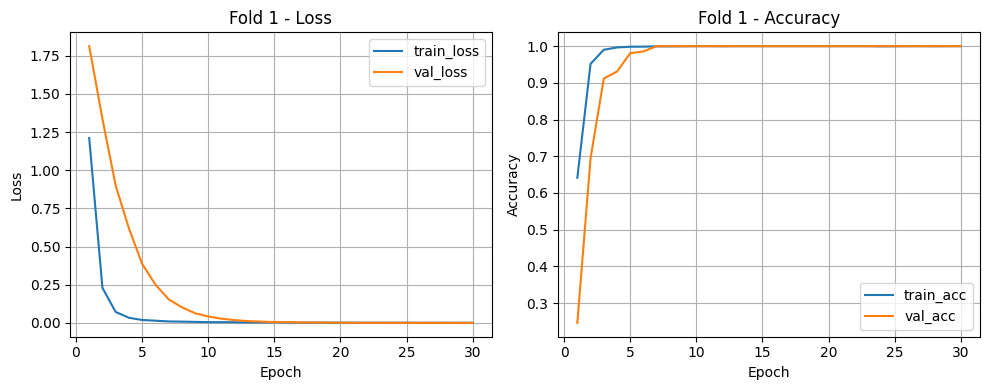

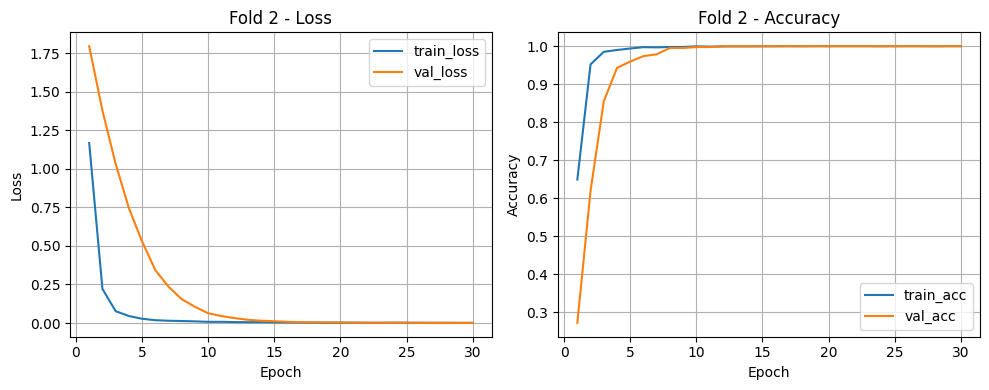

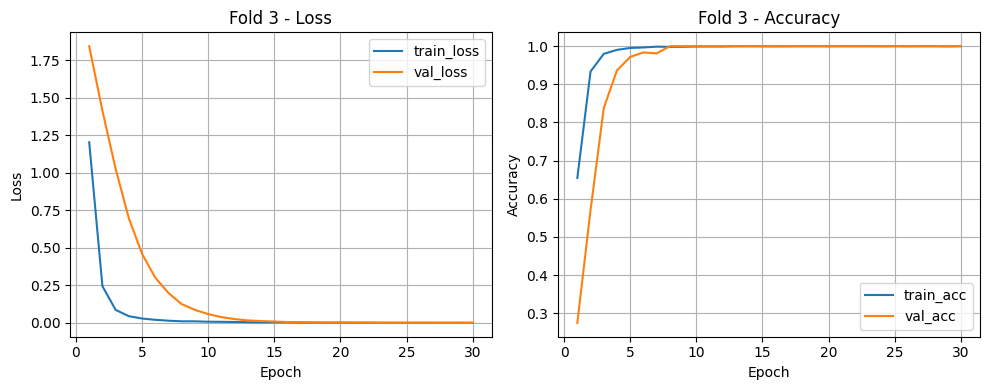

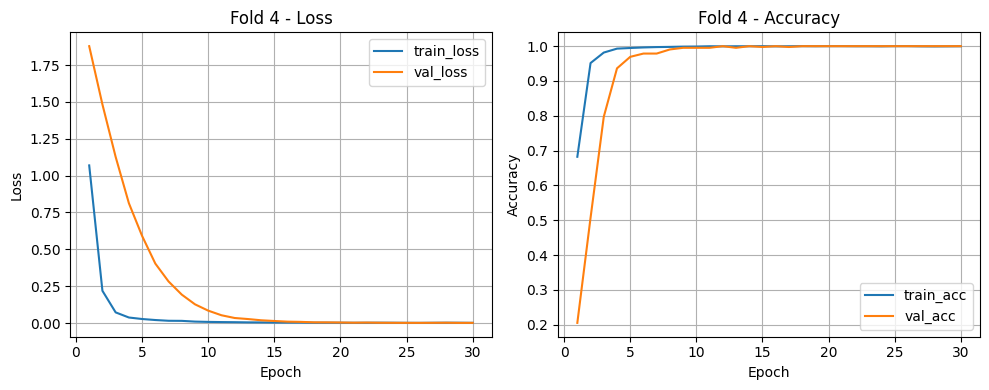

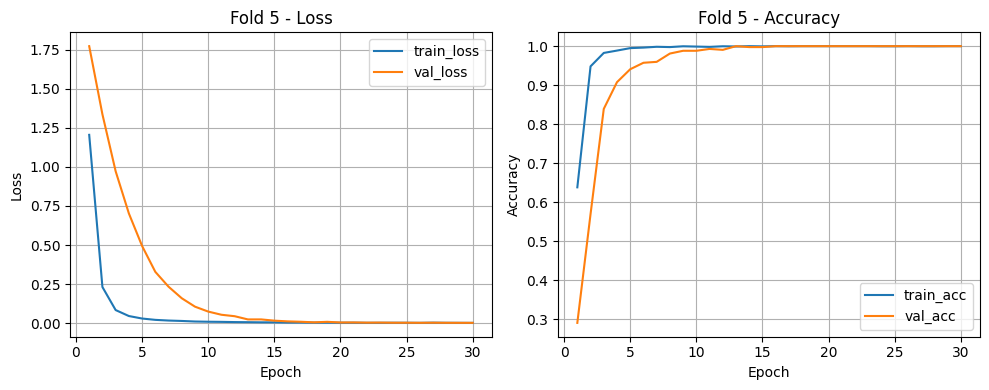

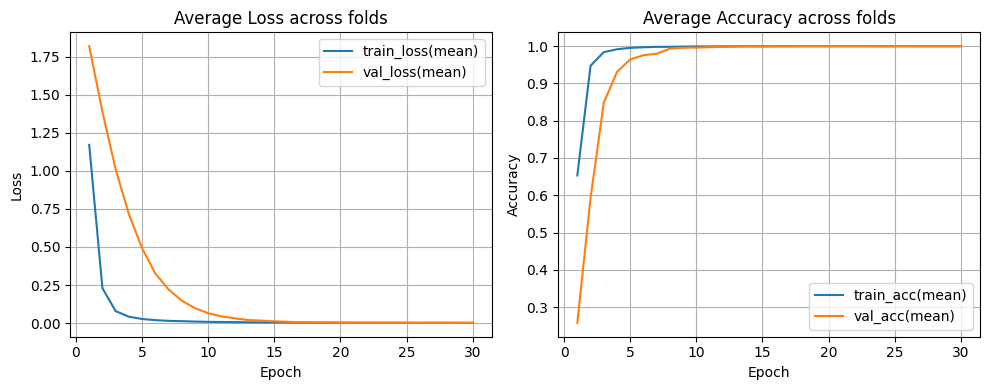

In [17]:
# === [시각화] fold별 및 평균 Loss/Accuracy ===
import numpy as np
import matplotlib.pyplot as plt

# fold별 그래프
for i, hist in enumerate(fold_histories, 1):
    loss = hist.get("loss", [])
    val_loss = hist.get("val_loss", [])
    acc = hist.get("accuracy", hist.get("acc", []))
    val_acc = hist.get("val_accuracy", hist.get("val_acc", []))

    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title(f'Fold {i} - Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(epochs, acc, label='train_acc')
    plt.plot(epochs, val_acc, label='val_acc')
    plt.title(f'Fold {i} - Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)

    plt.tight_layout()
    plt.show()

# 평균 그래프 (fold별 epoch 길이 다를 경우 평균 길이에 맞춤)
max_len = max(len(h.get("loss", [])) for h in fold_histories)
def pad(arr): return np.array(arr + [np.nan]*(max_len-len(arr)))
train_loss_mean = np.nanmean([pad(h.get("loss", [])) for h in fold_histories], axis=0)
val_loss_mean   = np.nanmean([pad(h.get("val_loss", [])) for h in fold_histories], axis=0)
train_acc_mean  = np.nanmean([pad(h.get("accuracy", h.get("acc", []))) for h in fold_histories], axis=0)
val_acc_mean    = np.nanmean([pad(h.get("val_accuracy", h.get("val_acc", []))) for h in fold_histories], axis=0)

epochs = range(1, max_len+1)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, train_loss_mean, label='train_loss(mean)')
plt.plot(epochs, val_loss_mean, label='val_loss(mean)')
plt.title('Average Loss across folds')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs, train_acc_mean, label='train_acc(mean)')
plt.plot(epochs, val_acc_mean, label='val_acc(mean)')
plt.title('Average Accuracy across folds')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()
